In [6]:
import cv2
import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import tensorflow as tf

from skimage import transform
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model

In [12]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [13]:
image_size = (224, 224)
input_shape = image_size + (3,)
num_classes = 5
batch_size = 32

In [14]:
data_dir = "datasets/"

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  validation_split=0.3,
  subset="training",
  label_mode="categorical",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  validation_split=0.3,
  subset="validation",
  label_mode="categorical",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

Found 1030 files belonging to 5 classes.
Using 721 files for training.
Found 1030 files belonging to 5 classes.
Using 309 files for validation.


In [16]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

In [76]:
print(f"Number of images for test set : {len(np.concatenate([i for x, i in test_ds], axis=0))}")

Number of images for test set : 192


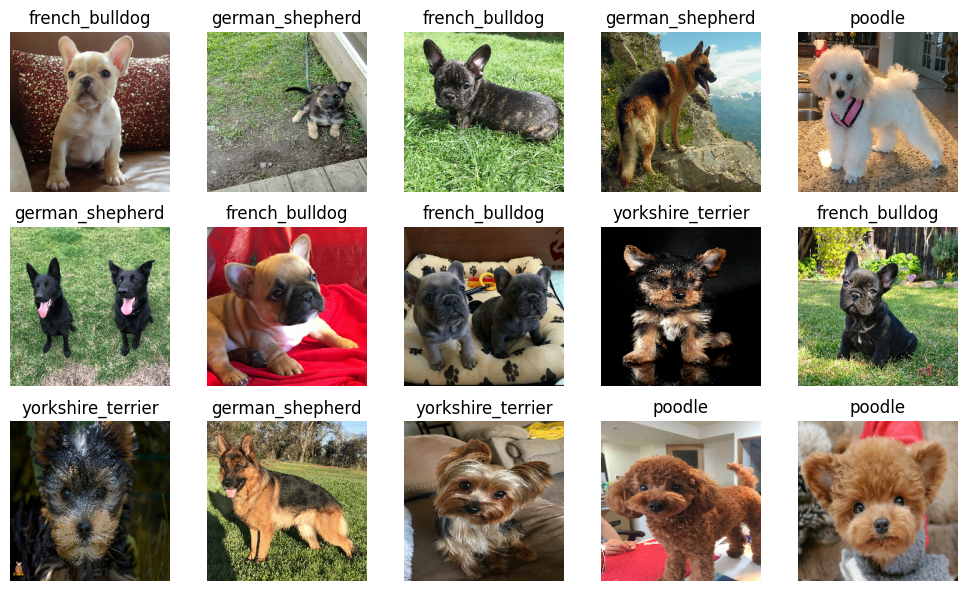

In [19]:
image_batch, label_batch = next(iter(train_ds))
images_to_show = image_batch[:15]
class_names = train_ds.class_names

fig, axes = plt.subplots(3, 5, figsize=(10,6))
axes = axes.flatten()
for img, label, ax in zip(images_to_show, label_batch[:15], axes):
    ax.imshow(img.numpy().astype("uint8"))
    ax.set_title(class_names[label.numpy().argmax()])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [78]:
inputs = tf.keras.Input(shape=input_shape)
x = tf.keras.layers.Lambda(preprocess_input)(inputs)

resnet_model = ResNet50(weights='imagenet', 
                        include_top=False, 
                        input_shape=input_shape,
                        input_tensor=x)

for layer in resnet_model.layers:
    layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(resnet_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=predictions)

In [79]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

In [80]:
checkpoint_path = "best_resnet.h5"
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

In [81]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[model_checkpoint, early_stopping])

Epoch 1/10
22/23 [===========================>..] - ETA: 0s - loss: 0.4748 - accuracy: 0.8409
Epoch 1: val_accuracy improved from -inf to 0.99145, saving model to best_resnet.h5
23/23 [==============================] - 12s 376ms/step - loss: 0.4659 - accuracy: 0.8433 - val_loss: 0.0302 - val_accuracy: 0.9915
Epoch 2/10
22/23 [===========================>..] - ETA: 0s - loss: 0.1035 - accuracy: 0.9645
Epoch 2: val_accuracy did not improve from 0.99145
23/23 [==============================] - 6s 207ms/step - loss: 0.1012 - accuracy: 0.9653 - val_loss: 0.0256 - val_accuracy: 0.9915
Epoch 3/10
22/23 [===========================>..] - ETA: 0s - loss: 0.0410 - accuracy: 0.9844
Epoch 3: val_accuracy did not improve from 0.99145
23/23 [==============================] - 6s 211ms/step - loss: 0.0401 - accuracy: 0.9847 - val_loss: 0.0568 - val_accuracy: 0.9915
Epoch 4/10
22/23 [===========================>..] - ETA: 0s - loss: 0.0329 - accuracy: 0.9901
Epoch 4: val_accuracy did not improve from 0

In [9]:
best_model = tf.keras.models.load_model("best_resnet.h5")

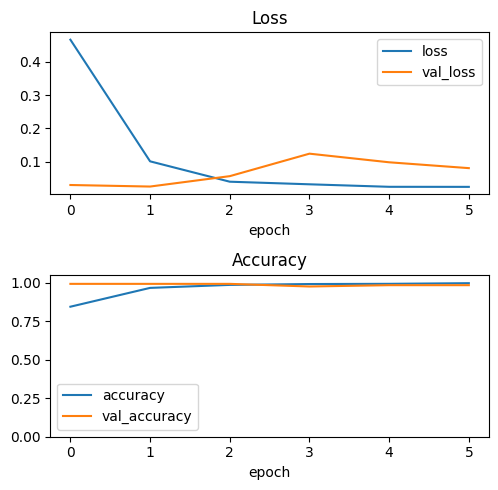

In [89]:
history_df = pd.DataFrame(history.history)

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(211)
ax1.set_title('Loss')
ax1.plot(history_df['loss'], label='loss')
ax1.plot(history_df['val_loss'], label='val_loss')
ax1.set_xlabel("epoch")
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.set_title('Accuracy')
ax2.plot(history_df['accuracy'], label='accuracy')
ax2.plot(history_df['val_accuracy'], label='val_accuracy')
ax2.set_xlabel("epoch")
ax2.legend()
ax2.set_ylim(0, 1.05) 

plt.tight_layout()
plt.show()

In [82]:
y_test_pred = []
y_test_true = []

for x, y in test_ds:
    y_test_pred.append(np.argmax(best_model(x), axis=-1))
    y_test_true.append(y.numpy())

y_test_pred = np.concatenate(y_test_pred, axis=0)
y_test_true = np.concatenate(y_test_true, axis=0)
y_test_true = np.argmax(y_test_true, axis=1)

print(classification_report(y_test_true, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        34
           1       0.97      1.00      0.98        56
           2       1.00      0.98      0.99        42
           3       0.97      0.97      0.97        29
           4       0.97      0.97      0.97        31

    accuracy                           0.98       192
   macro avg       0.98      0.98      0.98       192
weighted avg       0.98      0.98      0.98       192



In [83]:
print(confusion_matrix(y_test_true, y_test_pred))

[[33  1  0  0  0]
 [ 0 56  0  0  0]
 [ 0  1 41  0  0]
 [ 0  0  0 28  1]
 [ 0  0  0  1 30]]


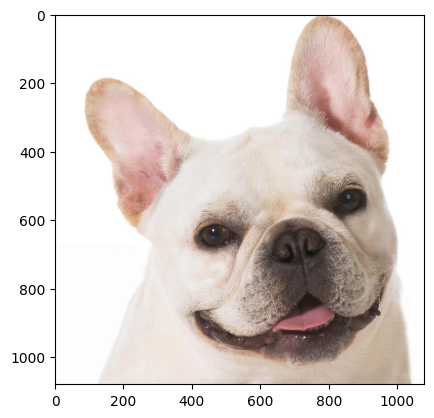

In [60]:
img = cv2.imread("datasets/french_bulldog/0200259a-2722-4576-86fb-6ead7393d8a0.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [56]:
def predict_image(img, probs=True):
    img = img.astype('float32')
    img = tf.image.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0)
    prediction = best_model.predict(img)[0]
    class_probs = {class_names[i]: float(prediction[i]) for i in range(5)}
    predicted_class = max(class_probs, key=class_probs.get)
    
    if probs == True:
        return class_probs
    else:
        return predicted_class

In [57]:
predict_image(img, probs=False)

1/1 [==============================] - 0s 16ms/step


'french_bulldog'

In [58]:
interface = gr.Interface(
    fn=predict_image, 
    inputs=gr.Image(shape=(224,224)),
    outputs=gr.Label(num_top_classes=5))

interface.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 26ms/step
